In [19]:
# import the necessary packages
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
import time
import sys

In [2]:
DEFAULT_CONFIG = {
    'init_learning_rate': None,
    'decay_steps': None,
    'decay_rate': 0.9,
    'staircase': True
    }

class cnn_model:
  def __init__(self, width, height, depth, classes, config=DEFAULT_CONFIG):
    self.input_shape = (height, width, depth) # dimensions of the input images
    self.channel_dim = -1 # channels dimension to be "channels last" ordering

    # Exponential decay schedule
    self.lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=config['init_learning_rate'],
        decay_steps=config['decay_steps'],
        decay_rate=config['decay_rate'],
        staircase=config['staircase']
    )
    # initialize optimizer
    self.opt = Adam(learning_rate=self.lr_schedule)


    self.model = Sequential([

      # Layer Set 1 - Input Layer:
      # CONV => RELU => BN => POOL
      # Conv - 16 filters with 3x3 kernal, produces 16 feature maps
      Conv2D(16, (3, 3), padding="same", input_shape=self.input_shape),
      Activation("relu"), # introduce non-linearity
      BatchNormalization(axis=self.channel_dim), # converge faster
      # reduce spatial dims (hgt & width) of each feature map
      MaxPooling2D(pool_size=(2, 2)),

      # Layer Set 2:
      # (CONV => RELU => BN) * 2 => POOL
      # Conv - 32 filters with 3x3 kernal
      Conv2D(32, (3, 3), padding="same"),
      Activation("relu"),
      BatchNormalization(axis=self.channel_dim),
      Conv2D(32, (3, 3), padding="same"),
      Activation("relu"),
      BatchNormalization(axis=self.channel_dim),
      MaxPooling2D(pool_size=(2, 2)),

      # Layer Set 3:
      # (CONV => RELU => BN) * 3 => POOL
      # Conv - 64 filters with 3x3 kernal
      Conv2D(64, (3, 3), padding="same"),
      Activation("relu"),
      BatchNormalization(axis=self.channel_dim),
      Conv2D(64, (3, 3), padding="same"),
      Activation("relu"),
      BatchNormalization(axis=self.channel_dim),
      Conv2D(64, (3, 3), padding="same"),
      Activation("relu"),
      BatchNormalization(axis=self.channel_dim),
      MaxPooling2D(pool_size=(2, 2)),

      # Layer Set 4:
      # Fully Connected layer => RELU layers
      Flatten(),
      Dense(256), # 256 neurons
      Activation("relu"),
      BatchNormalization(), # axis not specified bc 1-D
      # 50% dropout reduces overfitting, increasing model generalization
      Dropout(0.5),

      # Layer Set 5 - Output Layer:
      # softmax classifier
      # each neuron is probability score of respective class
      Dense(classes),
      Activation("softmax")
    ])


  def step(self, X, y):
    '''
    Custom training loop (step function) that
    encapsulates forward and backward pass of
    data (single step of gradient descent) using
    GradientTape and updating model weights.
    '''

    # keeps track of all operations that happen on trainable
    # variables onto a "tape" for automatic differentiation.
    with tf.GradientTape() as tape:
      # make a prediction using the model
      pred = self.model(X)

      # typical lf for multi-class classification
      loss = categorical_crossentropy(y, pred)

    # **** Automatic Differentiation ****
    # calculate gradients using tape & chain rule
    grads = tape.gradient(loss, self.model.trainable_variables)

    # optimizer updates the model weights using calculated gradients.
    self.opt.apply_gradients(zip(grads, self.model.trainable_variables))

  def fit(self, x_train, y_train, batch_size, epochs):
    # compute number of batch updates per epoch
    num_updates = int(x_train.shape[0] / batch_size)

    # loop over the number of epochs
    for epoch in range(0, epochs):

      # log current epoch number
      print("[INFO] starting epoch {}/{}...".format(epoch + 1, epochs), end="")
      sys.stdout.flush()
      epoch_start = time.time()

      # loop over the data in batch size increments
      for i in range(0, num_updates):

        # determine starting and ending
        # slice indexes for current batch
        start = i * batch_size
        end = start + batch_size

        # take a step - apply step function
        self.step(x_train[start:end], y_train[start:end])

      # log timing information for the epoch
      epoch_end = time.time()
      elapsed = (epoch_end - epoch_start) / 60.0
      print("[INFO] took {:.4} minutes".format(elapsed))


In [32]:
class GradCAM:
	def __init__(self, model, classIdx, layerName=None):
		# store the model, the class index used to measure the class
		# activation map, and the layer to be used when visualizing
		# the class activation map
		self.model = model.model
		self.classIdx = classIdx
		self.layerName = layerName
		# if the layer name is None, attempt to automatically find
		# the target output layer
		if self.layerName is None:
			self.layerName = self.find_target_layer()

	def find_target_layer(self):
   	# attempt to find the final convolutional layer in the network
		# by looping over the layers of the network in reverse order
		for layer in reversed(self.model.layers):
			# check to see if the layer has a 4D output
			if len(layer.output_shape) == 4:
				return layer.name
		# otherwise, we could not find a 4D layer so the GradCAM
		# algorithm cannot be applied
		raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


	def compute_heatmap(self, image, eps=1e-8):
		# construct our gradient model by supplying (1) the inputs
		# to our pre-trained model, (2) the output of the (presumably)
		# final 4D layer in the network, and (3) the output of the
		# softmax activations from the model
		gradModel = Model(
      inputs=[self.model.inputs],
      outputs=[self.model.get_layer(self.layerName).output,
      self.model.output]
    )

  		# record operations for automatic differentiation
		with tf.GradientTape() as tape:
			# cast the image tensor to a float-32 data type, pass the
			# image through the gradient model, and grab the loss
			# associated with the specific class index
			inputs = tf.cast(image, tf.float32)
			(convOutputs, predictions) = gradModel(inputs)
			loss = predictions[:, self.classIdx]
		# use automatic differentiation to compute the gradients
		grads = tape.gradient(loss, convOutputs)

  	# compute the guided gradients
		castConvOutputs = tf.cast(convOutputs > 0, "float32")
		castGrads = tf.cast(grads > 0, "float32")
		guidedGrads = castConvOutputs * castGrads * grads
		# the convolution and guided gradients have a batch dimension
		# (which we don't need) so let's grab the volume itself and
		# discard the batch
		convOutputs = convOutputs[0]
		guidedGrads = guidedGrads[0]

    # compute the average of the gradient values, and using them
		# as weights, compute the ponderation of the filters with
		# respect to the weights
		weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
		cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

    # grab the spatial dimensions of the input image and resize
		# the output class activation map to match the input image
		# dimensions
		(w, h) = (image.shape[2], image.shape[1])
		heatmap = cv2.resize(cam.numpy(), (w, h))
		# normalize the heatmap such that all values lie in the range
		# [0, 1], scale the resulting values to the range [0, 255],
		# and then convert to an unsigned 8-bit integer
		numer = heatmap - np.min(heatmap)
		denom = (heatmap.max() - heatmap.min()) + eps
		heatmap = numer / denom
		heatmap = (heatmap * 255).astype("uint8")
		# return the resulting heatmap to the calling function
		return heatmap

	def overlay_heatmap(self, heatmap,
                     image, alpha=0.5,
                     colormap=cv2.COLORMAP_VIRIDIS):
    # apply the supplied color map to the heatmap and then
    # overlay the heatmap on the input image
		heatmap = cv2.applyColorMap(heatmap, colormap)
		output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
    # return a 2-tuple of the color mapped heatmap and the output,
    # overlaid image
		return (heatmap, output)


In [3]:
# initialize Training Parameters
EPOCHS = 2
BATCH_SZ = 64
LRN_RATE = 1e-3

In [4]:
print("[INFO] loading MNIST dataset...")
((trainX, trainY), (testX, testY)) = mnist.load_data()

[INFO] loading MNIST dataset...


In [5]:
# add a channel dimension at last axis
# to every image in the dataset
trainX = np.expand_dims(trainX, axis=-1)

# normalize images to the range [0, 1]
# by rescaling the pixel intensities
testX = np.expand_dims(testX, axis=-1)
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

# one-hot encode the labels to
# allow the model to predict the
# probability of each class independently
trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

In [6]:
steps_per_epoch = len(trainX) // BATCH_SZ
decay_steps = steps_per_epoch * EPOCHS

In [7]:
config = {
    'init_learning_rate': LRN_RATE,
    'decay_steps': decay_steps,
    'decay_rate': 0.9,
    'staircase': True
}

model = cnn_model(28, 28, 1, 10, config=config)

In [8]:
model.fit(trainX, trainY, BATCH_SZ, EPOCHS)

[INFO] starting epoch 1/2...[INFO] took 4.949 minutes
[INFO] starting epoch 2/2...[INFO] took 5.119 minutes


In [9]:
# calculate accuracy using Keras functions.
model.model.compile(optimizer=model.opt, loss=categorical_crossentropy, metrics=["acc"])

# compute accuracy
(loss, acc) = model.model.evaluate(testX, testY)
print("[INFO] test loss: {:.4f}".format(loss))
print("[INFO] test accuracy: {:.4f}".format(acc))

313/313 [==============================] - 11s 34ms/step - loss: 0.0347 - acc: 0.9886
[INFO] test loss: 0.0347
[INFO] test accuracy: 0.9886


In [17]:
test_img = testX[0]
test_img.shape

(28, 28, 1)

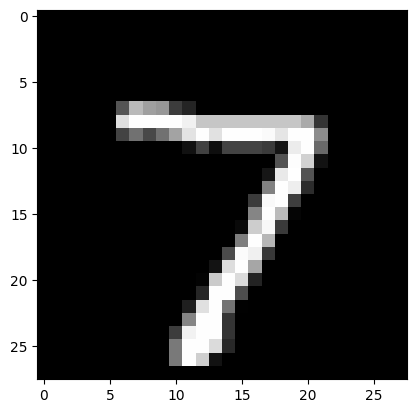

In [20]:
test_img = np.array(test_img, dtype='float')
pixels = test_img.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

In [27]:
image = np.expand_dims(testX[0], axis=0)  # Add batch dimension
predictions = model.model.predict(image)
predicted_label = np.argmax(predictions[0])
print(predicted_label)

1/1 [==============================] - 0s 320ms/step
7


In [38]:
# convert the image back to the range [0, 255]
image_to_save = (testX[0] * 255).astype("uint8")

# save the image
cv2.imwrite('test_img.png', image_to_save)

True

In [62]:
orig = cv2.imread('test_img.png')
orig_gray = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)

In [63]:
cam = GradCAM(model, predicted_label)
heatmap = cam.compute_heatmap(image)

In [64]:
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)

In [65]:
from google.colab.patches import cv2_imshow

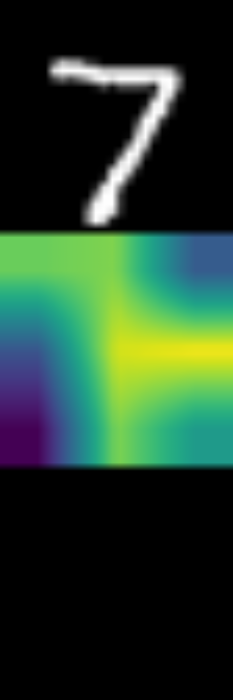

In [66]:
# draw the predicted label on the output image
cv2.rectangle(output, (0, 0), (340, 40), (0, 0, 0), -1)
# display the original image and resulting heatmap and output image
# to our screen
output = np.vstack([orig, heatmap, output])
# Calculate the aspect ratio
aspect_ratio = output.shape[1] / output.shape[0]
# Determine new width
new_width = int(aspect_ratio * 700)
# Resize the image
output_resized = cv2.resize(output, (new_width, 700))
cv2_imshow(output_resized)